In [1]:
import pickle, os, torch
import os.path as osp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import r2_score
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [41]:
from matplotlib.ticker import NullFormatter
from scipy import stats
from matplotlib.ticker import NullFormatter
from scipy import stats

def multi_plot(yss, preds):
    fig, ax = plt.subplots(2, 3, figsize=(23, 12))
    ax = ax.flatten()
#     target=r"log($SFR/M_{\odot}/yr$)"
    targets=[r"$log(v_{disk}/km/s)$", r"log($M_{cold}/M_{\odot}$)", r"log($SFR/M_{\odot}/yr$)"]
    targets=[r"$log(M_{*}/M_{\odot})$", r"log($M_{cold}/M_{\odot}$)", r"$log(Z_{gas})$", r"log($SFR/M_{\odot}/yr$)",
            r"log($SFR_{100}/M_{\odot}/yr$)", r"log($M_{BH}/M_{\odot}$)"]
    
    targets=[r"$M_*$", r"$M_{cold}$", r"$Z_{gas}$", r"$SFR$",
            r"$SFR_{100}$", r"$M_{BH}$"]
    # target=r"$v_{disk}$"
    for i in range(len(targets)):
        target=targets[i]
        ys = yss[:,i]
        pred = preds[:,i]
        nullfmt = NullFormatter()         # no labels
        # definitions for the axes
        left, width = 0.15, 0.67
        bottom, height = 0.0, 0.75
        bottom_h = bottom +height
        left_h = left + width
        # rect_Cbar = [0, bottom, 0.1, height]
        rect_scatter = [left, bottom, width, height]
        rect_histx = [left, bottom_h, width, 0.15]
        rect_histy = [left_h, bottom, 0.15+0.07, height]
#             rect_cbar = [left_h+0.15+0.06, bottom, 0.05, height]

        # start with a rectangular Figure
        ax[i].set_axis_off()
        # axCbar = plt.axes(rect_Cbar)
        axHist = ax[i].inset_axes(rect_scatter)
        axHistx = ax[i].inset_axes(rect_histx)
        axHisty = ax[i].inset_axes(rect_histy)
#             axCbar = ax[i][j].inset_axes(rect_cbar)

        # no labels
        axHistx.xaxis.set_major_formatter(nullfmt)
        axHisty.yaxis.set_major_formatter(nullfmt)
        axHistx.yaxis.set_major_formatter(nullfmt)
        axHisty.xaxis.set_major_formatter(nullfmt)

        bins=50
        l=0.0
        n_contour=4
        # the scatter plot:
        vals, x, y, hist =axHist.hist2d( ys, pred,bins=bins, range=[np.percentile(np.hstack([ys,pred]), [0+l,100-l]),
                                    np.percentile(np.hstack([ys,pred]), [0+l,100-l])], norm=mpl.colors.LogNorm(), cmap=mpl.cm.viridis)
        X, Y = np.meshgrid((x[1:]+x[:-1])/2, (y[1:]+y[:-1])/2)
        axHist.contour(X,Y, np.log(vals.T+1), levels=n_contour, colors='white')
        axHist.plot([min(ys),max(ys)],[min(ys),max(ys)], 'k--', label='Perfect correspondance')
        axHist.set(xlabel=f'Run 1 {target}',ylabel=f'Run 2 {target}')
        axHist.xaxis.label.set_fontsize(13)
        axHist.yaxis.label.set_fontsize(13)
        
        if i==0:
            axHist.legend(fontsize=12, loc='upper left')

        X, Y = X[0], Y.T[0]
        axHist.set_xlim((min(X), max(X)))
        axHist.set_ylim((min(Y), max(Y)))
        yhat=r'$\hat{y}$'

        #calculate metrics
        pct=np.sum(np.abs(ys-pred)<0.2)/len(ys-pred)    
        r2=r2_score(ys,pred)
        rho = np.corrcoef(ys,pred)[0,1]
        print('bias', np.mean(ys-pred))
        print('std', np.std(ys-pred))
        print('rho', rho)
        print('r2', r2)
        print('pct',pct)
        
        xt=0.55
        yt=0.18
        dy=0.06
        font = {'weight': 'normal',
            'size': 12}

        axHist.text(xt,yt, f'Bias : {np.mean(ys-pred):.3f} dex', fontdict=font, transform=axHist.transAxes)
        axHist.text(xt,yt-dy, r'$\sigma$ : '+f'{np.std(ys-pred):.3f} dex', fontdict=font, transform=axHist.transAxes)
        axHist.text(xt,yt-2*dy, r'Pearson:  '+f'{rho:.3f}', fontdict=font, transform=axHist.transAxes)
        
        ticks = axHist.get_yticks()
        axHist.set(xticks=ticks[1:-1])
                
        ys_kde = stats.gaussian_kde(ys, 0.1)
        pred_kde = stats.gaussian_kde(pred, 0.1)
        axHistx.plot(X, ys_kde(X), 'k--', label=f'Run 1')
        axHisty.plot(pred_kde(Y), Y, "k-.", label=f'Run 2')
        axHistx.legend(fontsize=12)
        axHisty.legend(loc='upper left', bbox_to_anchor=(0.,1.15), fontsize=12)

        font = {'family' : 'Serif',
                'weight' : 'normal',
                'size'   : 16}

        matplotlib.rc('font', **font)

        axHistx.set(title=f'Two SAM {target}', )

        axHistx.set_xlim(axHist.get_xlim())
        axHisty.set_ylim(axHist.get_ylim())

        divider = make_axes_locatable(axHisty)
        cax = divider.append_axes("right", size="15%", pad=0.18)
        divider = make_axes_locatable(axHist)
#             cax = divider.append_axes("left", size="15%", pad=0.18)

        # Plot vertical colorbar
        plt.colorbar(hist, cax=cax)
#             plt.show()
#             plt.colorbar(hist, ax=axCbar)

#             plt.show()
#     fig.tight_layout()
#     plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=None)
    return fig

In [42]:
# this is the final halo run
folder = 'results_SAM'
run = 'SAM01'
pointer=osp.expanduser(f'~/../../scratch/gpfs/cj1223/GraphResults/{folder}/{run}')   
results=pickle.load(open(osp.join(pointer,'result_dict.pkl'), 'rb'))
ys, pred = results['ys'], results['pred']
mstar_ys, mstar_pred = ys[:,0]+9, pred[:,0]+9
# mcold_ys, mcold_pred = ys[:,2]+9, pred[:,2]+9

Zy, Zpred = ys[:,2], pred[:,2]
Coldy, Coldpred = ys[:,1]+9, pred[:,1]+9
sfr_ys, sfr_pred = ys[:,3], pred[:,3]
sfr100_ys, sfr100_pred = ys[:,4], pred[:,4]
Mbh_ys, Mbh_pred = ys[:,5]+9, pred[:,5]+9

In [43]:
ys = np.vstack([ mstar_ys, Coldy, Zy, sfr_ys, sfr100_ys, Mbh_ys]).T
pred = np.vstack([mstar_pred, Coldpred, Zpred, sfr_pred, sfr100_pred, Mbh_pred]).T

bias 0.0001942948230829009
std 0.04275108896463535
rho 0.9989751653491693
r2 0.9979509249546455
pct 0.9924302049539605
bias -0.00016463430543939473
std 0.09567129958199824
rho 0.9835247010287993
r2 0.9670726446164387
pct 0.9644993889134177
bias -6.541407273329052e-05
std 0.07462269780073864
rho 0.9902542994926304
r2 0.9805176314355747
pct 0.9905873469883989
bias -2.2615455990008735e-05
std 0.23009608142602989
rho 0.973566430977963
r2 0.947187558164138
pct 0.9148893965280044
bias -0.00030309729867534596
std 0.19906468650173162
rho 0.9800296215749141
r2 0.9600987754464507
pct 0.9239373172339214
bias -0.00022973525820749435
std 0.12926986496934473
rho 0.9662220108617464
r2 0.9323253795932186
pct 0.9099047216836555


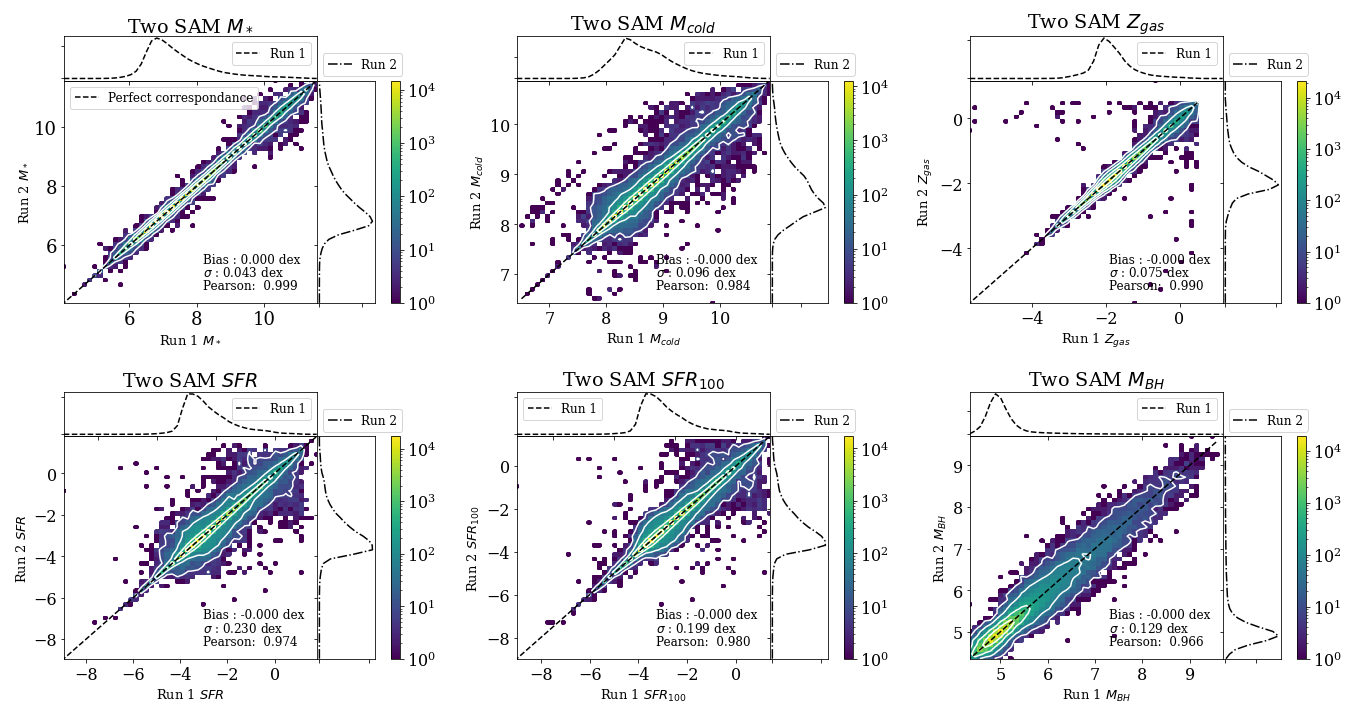

In [44]:
import matplotlib
font = {'family' : 'Serif',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)
fig=multi_plot(ys, pred)
#0.16064388

In [45]:
fig.savefig('../paper_figures/SAM_variability.png')